In [268]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [269]:
import random
import numpy as np

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# For even more determinism (may slow down training)
tf.config.experimental.enable_op_determinism()

In [270]:
train_data = pd.read_csv('data/train.csv')
valid_data = pd.read_csv('data/valid.csv')
test_data = pd.read_csv('data/test.csv')

In [271]:
# 2. Map string labels to integers (right after loading)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_data['label'] = train_data['label'].map(label_map)
valid_data['label'] = valid_data['label'].map(label_map)
test_data['label']  = test_data['label'].map(label_map)

# (Optional but recommended) drop rows with unmapped or NaN labels
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data  = test_data.dropna()


In [272]:
# Ambil teks dan label
train_texts, train_labels = train_data['text'], train_data['label']
valid_texts, valid_labels = valid_data['text'], valid_data['label']
test_texts,  test_labels  = test_data['text'],  test_data['label']

In [273]:
from tensorflow.keras.layers import TextVectorization

# Buat vectorizer berdasarkan training saja
vectorizer = TextVectorization(max_tokens=20000, output_mode="int", output_sequence_length=100)
vectorizer.adapt(train_texts)

In [274]:
# Siapkan dataset TensorFlow
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_texts, valid_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((test_texts,  test_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [275]:
# Add this before training to check data types
print("Sample text:", train_texts.iloc[0])
print("Sample label:", train_labels.iloc[0], "Type:", type(train_labels.iloc[0]))

# Check the shape and first few elements of each dataset
print("\nFirst batch of train_ds:")
for text_batch, label_batch in train_ds.take(1):
    print("Text shape:", text_batch.shape)
    print("Label shape:", label_batch.shape)
    print("Label values:", label_batch.numpy())

Sample text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!
Sample label: 1 Type: <class 'numpy.int64'>

First batch of train_ds:
Text shape: (32,)
Label shape: (32,)
Label values: [1 2 1 2 2 1 1 0 0 2 2 0 0 2 2 2 1 1 1 0 1 2 2 0 1 0 0 0 0 2 2 1]


In [276]:
# Import required modules
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense


model = Sequential([
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [277]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [278]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_ds, validation_data=valid_ds, epochs=100, callbacks=[early_stopping])


# Evaluasi akhir
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nAkurasi akhir pada test set: {test_acc:.4f}")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.4217 - loss: 1.0480 - val_accuracy: 0.5100 - val_loss: 0.9953
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8681 - loss: 0.6760 - val_accuracy: 0.5100 - val_loss: 1.0112
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9690 - loss: 0.3723 - val_accuracy: 0.5400 - val_loss: 0.9046
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9818 - loss: 0.1778 - val_accuracy: 0.4800 - val_loss: 1.0455
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9928 - loss: 0.0978 - val_accuracy: 0.6400 - val_loss: 0.8403
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9979 - loss: 0.0401 - val_accuracy: 0.6200 - val_loss: 0.9208
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.6600 - val_loss: 0.9073
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Macro F1-Score: 0.6315

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.67      0.61       153
     Neutral       0.58      0.44      0.50        96
    Positive       0.79      0.77      0.78       151

    accuracy                           0.65       400
   macro avg       0.65      0.63      0.63       400
weighted avg       0.65      0.65      0.65       400



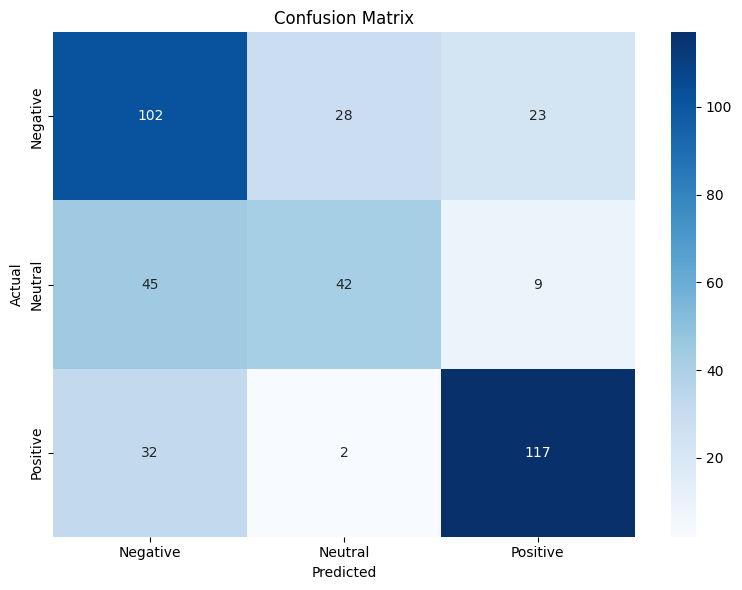

In [279]:
# Import necessary metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from test dataset (need to extract from the TensorFlow dataset)
test_labels_list = []
for _, labels in test_ds:
    test_labels_list.append(labels.numpy())
y_true = np.concatenate(test_labels_list, axis=0)
y_true = y_true[:len(y_pred)]  # Match lengths in case of incomplete batches

# Calculate macro F1-score
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"\nMacro F1-Score: {f1_macro:.4f}")

# Get detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Extract weights

In [280]:
# 1. Embedding weights
embedding_weights = model.layers[1].get_weights()[0]  # Shape: (20000, 128)

# 2. RNN weights (Bidirectional contains forward and backward)
# Each contains: [kernel, recurrent_kernel, bias]
rnn_forward_weights = model.layers[2].forward_layer.get_weights()
rnn_backward_weights = model.layers[2].backward_layer.get_weights()

rnn_f_kernel, rnn_f_recurrent, rnn_f_bias = rnn_forward_weights
rnn_b_kernel, rnn_b_recurrent, rnn_b_bias = rnn_backward_weights

# 3. Dense layer weights
dense_weights, dense_bias = model.layers[4].get_weights()

np.savez("rnn_weights.npz",
         embedding=embedding_weights,
         rnn_f_kernel=rnn_f_kernel,
         rnn_f_recurrent=rnn_f_recurrent,
         rnn_f_bias=rnn_f_bias,
         rnn_b_kernel=rnn_b_kernel,
         rnn_b_recurrent=rnn_b_recurrent,
         rnn_b_bias=rnn_b_bias,
         dense_w=dense_weights,
         dense_b=dense_bias)

In [281]:
# Create a new cell in rnn_classification.ipynb
import numpy as np

# Load the saved weights
weights = np.load('rnn_weights.npz')

# Extract individual weights
embedding = weights['embedding']
rnn_f_kernel = weights['rnn_f_kernel']
rnn_f_recurrent = weights['rnn_f_recurrent']
rnn_f_bias = weights['rnn_f_bias']
rnn_b_kernel = weights['rnn_b_kernel']
rnn_b_recurrent = weights['rnn_b_recurrent']
rnn_b_bias = weights['rnn_b_bias']
dense_w = weights['dense_w']
dense_b = weights['dense_b']

# Print shapes to verify
print(f"Embedding shape: {embedding.shape}")
print(f"RNN forward kernel shape: {rnn_f_kernel.shape}")
print(f"RNN forward recurrent shape: {rnn_f_recurrent.shape}")
print(f"RNN forward bias shape: {rnn_f_bias.shape}")
print(f"Dense weights shape: {dense_w.shape}")
print(f"Dense bias shape: {dense_b.shape}")

Embedding shape: (20000, 128)
RNN forward kernel shape: (128, 64)
RNN forward recurrent shape: (64, 64)
RNN forward bias shape: (64,)
Dense weights shape: (128, 3)
Dense bias shape: (3,)


## Predict Scratch Model

In [282]:
# Import your custom implementations
from preprocessing import preprocess_text
from simpleRNN import SimpleRNN
from bidirectional import Bidirectional
from network import Network
from dense import Dense
from embedding import Embedding
from tensorflow.keras.layers import Embedding, Dropout

# Create embedding layer using your custom implementation
# embedding_layer = Embedding(embedding)

# Create bidirectional RNN layer
forward_rnn = SimpleRNN(rnn_f_kernel, rnn_f_recurrent, rnn_f_bias)
backward_rnn = SimpleRNN(rnn_b_kernel, rnn_b_recurrent, rnn_b_bias)
bidirectional_layer = Bidirectional(forward_rnn, backward_rnn)

# Create dense layer for classification
dense_layer = Dense(dense_w, dense_b, activation="softmax")


# Bangun model seperti sebelumnya
network = Network([
    vectorizer,
    Embedding(input_dim=20000, output_dim=128, mask_zero=True),
    bidirectional_layer,
    Dropout(0.5),
    dense_layer
])


In [284]:
def evaluate_scratch_model(test_ds, network):
    all_predictions = []
    all_labels = []
    
    # Process data in batches
    batch_count = 0
    for text_batch, label_batch in test_ds:
        batch_count += 1
        print(f"Processing batch {batch_count}...")
        
        # Convert to numpy and process
        texts = text_batch.numpy()
        labels = label_batch.numpy()
        
        # Get predictions for the batch
        batch_predictions = []
        for text in texts:
            # Forward pass through the network
            output = network.forward(text)
            pred = np.argmax(output)
            batch_predictions.append(pred)
        
        # Store results
        all_predictions.extend(batch_predictions)
        all_labels.extend(labels)
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = np.mean(all_predictions == all_labels)
    f1 = f1_score(all_labels, all_predictions, average='macro')
    
    return accuracy, f1, all_predictions, all_labels

# Evaluate the model
from sklearn.metrics import f1_score, classification_report

print("Starting evaluation of scratch model...")
accuracy, f1, predictions, true_labels = evaluate_scratch_model(test_ds, network)

print(f"\nScratch model accuracy: {accuracy:.4f}")
print(f"Scratch model F1-score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['Negative', 'Neutral', 'Positive']))

# Optional: Generate confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Scratch Model)')
plt.tight_layout()
plt.show()

Starting evaluation of scratch model...
Processing batch 1...


AttributeError: 'TextVectorization' object has no attribute 'forward'

In [ ]:
# # Function to evaluate on test data
# def evaluate_scratch_model(test_texts, test_labels, vectorizer):
#     predictions = []
    
#     for text in test_texts:
#         vectorized_text = vectorizer(text)
#         output = network.forward(vectorized_text)
#         pred = np.argmax(output)
#         predictions.append(pred)
    
#     # Convert to numpy arrays
#     predictions = np.array(predictions)
    
#     # Calculate accuracy
#     accuracy = np.mean(predictions == test_labels)
    
#     # Calculate F1 score (requires sklearn)
#     from sklearn.metrics import f1_score
#     f1 = f1_score(test_labels, predictions, average='macro')
    
#     return accuracy, f1, predictions

# # Sample from test data
# sample_size = 100  # Adjust based on your available memory and computation power
# sample_texts = test_texts[:sample_size]
# sample_labels = test_labels[:sample_size]

# # Evaluate
# accuracy, f1_score, predictions = evaluate_scratch_model(sample_texts, sample_labels, vectorizer)
# print(f"Scratch model accuracy: {accuracy:.4f}")
# print(f"Scratch model F1-score: {f1_score:.4f}")

AttributeError: 'TextVectorization' object has no attribute 'forward'